In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
!pwd

/Users/josh/Documents/Harvard/Rich-ANN/RichieHakim BMI_IDAP main ROI_Classifiers


In [ ]:
import sys
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io import savemat
import scipy.signal

import torch
import torchvision
import torchvision.transforms as transforms

import os

# for reading and displaying images
from skimage.io import imread
# for creating validation set
from sklearn.model_selection import train_test_split
# for evaluating the model
from sklearn.metrics import accuracy_score

import pathlib
from imgaug import augmenters as iaa


%matplotlib notebook
%matplotlib notebook
%matplotlib inline
# %matplotlib qt

In [ ]:
# torch.cuda.current_device()

In [4]:
# torch.cuda.get_device_name(0)

In [5]:
dup_num = 1

Load and preprocess stat file and labels  
Labels must be made in the 'ROI_labeling_and_augmentation' script and the relabeling script  
## outputs: 'images' and 'labels' (both input into CNN)


PATH:   /Users/josh/Documents/Harvard/Rich-ANN/RichieHakim BMI_IDAP main ROI_Classifiers/label data/mouse 6_28 _ day 20200903/stat.npy

stat file loaded

Number of ROIs: 4868


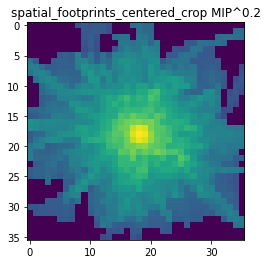

In [6]:
# LOAD stat.npy file 1
#___________________


# dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
fileName_load = 'stat.npy'

PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

stat = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
print('stat file loaded')
print('')

num_ROI = stat.shape[0]
print(f'Number of ROIs: {num_ROI}')

height = 512
width = 1024
spatial_footprints_centered = np.zeros((num_ROI, 241,241))
for i in range(num_ROI):
    spatial_footprints_centered[i , stat[i]['ypix'] - np.int16(stat[i]['med'][0]) + 120, stat[i]['xpix'] - np.int16(stat[i]['med'][1]) + 120] = stat[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop = spatial_footprints_centered[:, 102:138 , 102:138]

# %matplotlib inline
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

images = spatial_footprints_centered_crop

PATH:   /Users/josh/Documents/Harvard/Rich-ANN/RichieHakim BMI_IDAP main ROI_Classifiers/label data/mouse6_28 _ day20200815/stat.npy

stat file loaded

Number of ROIs: 4847


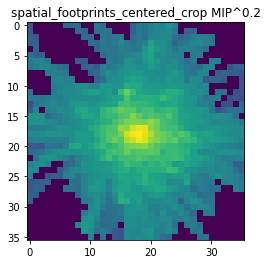

In [7]:
# LOAD stat.npy file 2
#___________________


# dir_load = '\\\\research.files.med.harvard.edu\\Neurobio\\MICROSCOPE\\Rich\\data\\res2p\\scanimage data\\round 4 experiments\\mouse 6.28\\20200815\\suite2p\\plane0\\'
fileName_load = 'stat.npy'

PATH_absolute = pathlib.Path('.').absolute()
# PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
# PATH_load_dir_statFile = '/media/rich/Home_Linux_partition/GoogleDrive_ocaml_cache/Research/Sabatini Lab Stuff - working/Code/PYTHON/ROI_Classifiers/test data_mouse6_28 _ 20200815/'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

stat2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}', allow_pickle=True)
print('stat file loaded')
print('')

num_ROI2 = stat2.shape[0]
print(f'Number of ROIs: {num_ROI2}')

height = 512
width = 1024
spatial_footprints_centered2 = np.zeros((num_ROI2, 241,241))
for i in range(num_ROI2):
    spatial_footprints_centered2[i , stat2[i]['ypix'] - np.int16(stat2[i]['med'][0]) + 120, stat2[i]['xpix'] - np.int16(stat2[i]['med'][1]) + 120] = stat2[i]['lam'] # this is formatted for coding ease (dim1: y pix) (dim2: x pix) (dim3: ROI#)
spatial_footprints_centered_crop2 = spatial_footprints_centered2[:, 102:138 , 102:138]

# %matplotlib inline
plt.figure()
plt.imshow(np.max(spatial_footprints_centered_crop2 , axis=0) ** 0.2);
plt.title('spatial_footprints_centered_crop MIP^0.2');

# images = spatial_footprints_centered_crop

In [8]:
images = np.concatenate((spatial_footprints_centered_crop , spatial_footprints_centered_crop2) , axis = 0)
print(images.shape)

(9715, 36, 36)


PATH:   /Users/josh/Documents/Harvard/Rich-ANN/RichieHakim BMI_IDAP main ROI_Classifiers/label data/mouse 6_28 _ day 20200903/labels_posthoc_filledIn_allCells.npy

labels file loaded



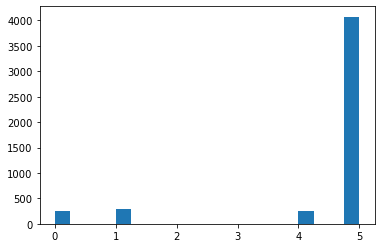

In [9]:
# LOAD labels file 1
#___________________

num_labels = 6

PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse 6_28 _ day 20200903/'
fileName_load = 'labels_posthoc_filledIn_allCells.npy'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

labels1 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
print('labels file loaded')
print('')


plt.figure()
# plt.hist(labels,20);
plt.hist(labels1,20);


#check in number of labels matches number of images
if images.shape[0] == len(labels1):
    print('number of labels and images match')
else:
    print('WARNING: number of labels and images DO NOT match')


In [10]:
images.shape, labels1.shape

((9715, 36, 36), (4868,))

PATH:   /Users/josh/Documents/Harvard/Rich-ANN/RichieHakim BMI_IDAP main ROI_Classifiers/label data/mouse6_28 _ day20200815/labels_posthoc_all.npy

labels file loaded



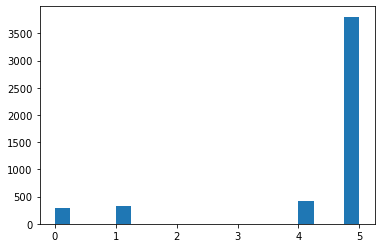

In [11]:
# LOAD labels file 2
#___________________

num_labels = 6

PATH_absolute = pathlib.Path('.').absolute()
PATH_load_dir_statFile = f'{PATH_absolute}/label data/mouse6_28 _ day20200815/'
fileName_load = 'labels_posthoc_all.npy'
print(f'PATH:   {PATH_load_dir_statFile}{fileName_load}')
print('')

labels2 = np.load(f'{PATH_load_dir_statFile}{fileName_load}')
print('labels file loaded')
print('')


plt.figure()
# plt.hist(labels,20);
plt.hist(labels2,20);


#check in number of labels matches number of images
if images.shape[0] == len(labels2):
    print('number of labels and images match')
else:
    print('WARNING: number of labels and images DO NOT match')

In [12]:
labels = np.concatenate((labels1 , labels2))
print(labels.shape)

(9715,)


In [13]:
np.save('temp_images.npy', images)

In [14]:
np.save('temp_labels.npy', labels)

In [15]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(images[:], labels[:], test_size = 0.15)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((8257, 36, 36), (8257,)), ((1458, 36, 36), (1458,)))

In [16]:
# importing the libraries
import pandas as pd

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid, SELU, GELU, ELU, PReLU, Softplus, Softmax2d, AvgPool2d, Tanh
from torch.optim import Adam, SGD

counts = np.histogram(labels,np.arange(7))

weightings_groups_forSampling = np.zeros(6)
for ii in np.array([0,1,4,5]):
    weightings_groups_forSampling[ii] = np.max(counts[0]) / counts[0][ii]

plt.figure()
plt.bar(range(6), weightings_groups_forSampling)

# %matplotlib qt
weightings_forSampling = np.zeros(len(labels)) + 1e-9
for ii in range(len(weightings_forSampling)):
    weightings_forSampling[ii] = weightings_groups_forSampling[labels[ii]]

weightings_forSampling = weightings_forSampling / np.sum(weightings_forSampling)
plt.figure()
plt.plot(weightings_forSampling)
plt.plot(scipy.signal.savgol_filter(weightings_forSampling,11,2))

# light data augmentation
duplicates = 10

# duplication to equalize the probability of encountering each case

images_dup = train_x[0][None,:,:]
labels_aug = np.array([val_y[0]])

for ii in range(6):
    images_dup = np.concatenate( ( images_dup , np.tile(images[labels==ii] ,( np.int16(weightings_groups_forSampling[ii]) , 1 , 1 ) )), axis=0)
    labels_aug = np.concatenate( ( labels_aug , np.ones( np.int16(weightings_groups_forSampling[ii]) * np.sum(labels==ii) ) * ii) )
images_dup = np.tile(images_dup , (duplicates,1,1))
# images_dup = images_dup / np.tile(np.max(images_dup , axis=(1,2)) , (images_dup.shape[1], images_dup.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1
labels_aug = np.tile(labels_aug , duplicates)

test = np.ones(images_dup.shape[0]) * np.nan
images_dup_int8 = np.int8(np.zeros_like(images_dup))
images_dup_uint8 = np.uint8(np.zeros_like(images_dup))
for ii , val in enumerate(images_dup):
    images_dup_int8[ii] = np.int8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) ) -0.5) * 122))
    images_dup_uint8[ii] = np.uint8(np.round((( images_dup[ii] / np.max(images_dup[ii], axis=(0,1)) )) * 122))
    test[ii] = np.mean(images_dup_uint8[ii], axis=(0,1))

In [17]:
duplicates = dup_num

images_dup = np.tile(train_x , (duplicates , 1 , 1))
labels_aug = np.tile(train_y , (duplicates))

print(images_dup.shape)
print(labels_aug.shape)

numToGetTo = np.sum(labels_aug==0)
print(numToGetTo)
for ii in np.array([1,4,5]):
#     idxToDelete = np.cumsum(labels_aug==ii) <= (np.sum(labels_aug==ii) - numToGetTo)
    if ii==5:
        numToGetTo = np.sum(labels_aug==0)/2
    else:
        numToGetTo = np.sum(labels_aug==0)

    idxToDelete = (np.cumsum(labels_aug==ii) * (labels_aug==ii)) > numToGetTo
    images_dup = images_dup[idxToDelete==0,:,:]
    labels_aug = labels_aug[idxToDelete==0]


print(np.sum(labels_aug==0))
print(np.sum(labels_aug==1))
print(np.sum(labels_aug==4))
print(np.sum(labels_aug==5))
print(images_dup.shape)
print(labels_aug.shape)

(8257, 36, 36)
(8257,)
442
442
442
442
221
(1548, 36, 36)
(1548,)


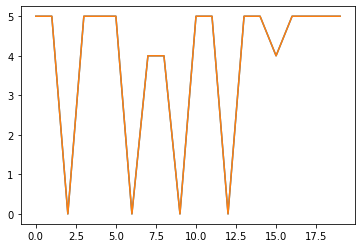

In [18]:
# %matplotlib inline
# %matplotlib inline

plt.figure()
plt.plot(labels_aug[:20])
plt.plot(train_y[:20])
# plt.plot(scipy.signal.savgol_filter(labels_aug , 11 , 3))

# plt.figure()
# plt.imshow(images_dup[5]);
# print(images_dup.dtype)

In [20]:
aug_seq = iaa.Sequential([], random_order=True) # apply augmenters in random order

np.save('images_aug.npy' , images_aug)

images_aug = np.load('images_aug.npy')

(1548, 36, 36)
float64
float64


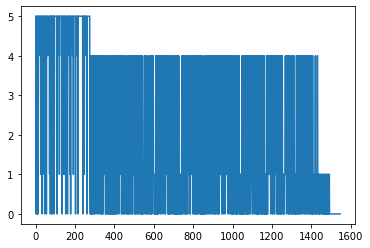

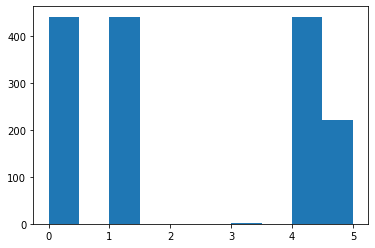

In [21]:
# images_aug = aug_seq(images=images_dup_uint8)
images_aug = aug_seq(images=images_dup)
# images_aug = images_dup
# images_aug = images_aug

# images_aug = images_aug / np.tile(np.max(images_aug , axis=(1,2)) , (images_aug.shape[1], images_aug.shape[2], 1)).transpose(2,0,1) # noramlized all the images' max values to 1

print(images_aug.shape)

# plt.figure()
# plt.imshow(images_dup_uint8[6])
plt.figure()
plt.plot(labels_aug)
plt.figure()
plt.hist(labels_aug);

print(images_dup.dtype)
print(images_aug.dtype)

# print(images_aug.shape)
# print(labels_aug.shape)

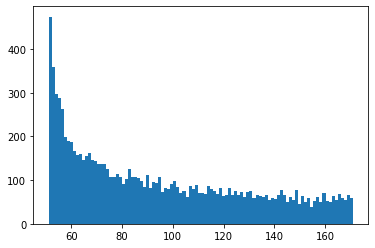

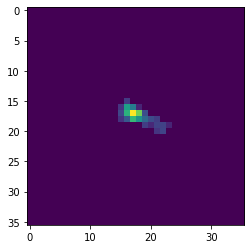

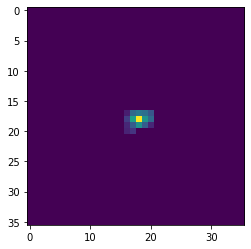

In [22]:
# noiseGain_inverse = np.random.rand(1)**2 * 100 + 10
# plt.figure()
# test = (100 * ( np.random.rand(10000) + 0.1 )**2)+12
# plt.hist(test[test < 1000],100);
noiseGain_inverse = lambda x: (100 * ( np.random.rand(x) + 0.1 )**2)+50
plt.figure()
plt.hist(noiseGain_inverse(10000),100)

images_toUse = images_aug

images_aug_noisy = np.zeros_like(images_toUse)
for ii in range(images_toUse.shape[0]):
    if np.random.rand(1) < 0.8:
        noise = noiseGain_inverse(1)
#         images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) ) * noise / noise * np.max(images_toUse[ii])   # noisy image
        images_aug_noisy[ii] = np.random.poisson(images_toUse[ii] / np.max(images_toUse[ii]) * noise) / noise * np.max(images_toUse[ii])   # noisy image
    else:
        images_aug_noisy[ii] = images_toUse[ii]
plt.figure()
plt.imshow(images_aug_noisy[0])
plt.figure()
plt.imshow(images_aug_noisy[1])

np.save('images_aug.npy' , images_aug)

In [23]:
%matplotlib notebook
plt.figure()
plt.imshow(images_aug_noisy[8])
print(np.sum(images_aug_noisy[8]))

<IPython.core.display.Javascript object>

0.9959041920083151


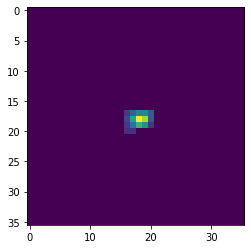

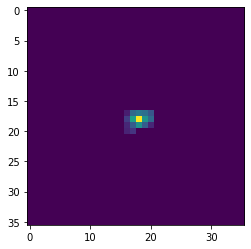

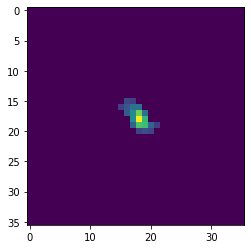

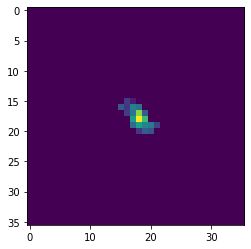

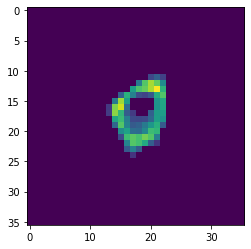

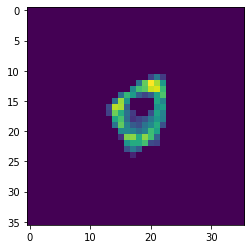

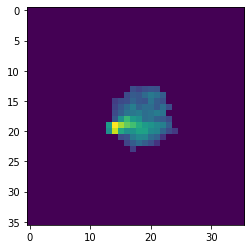

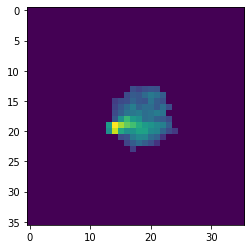

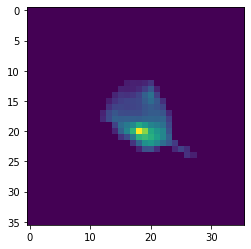

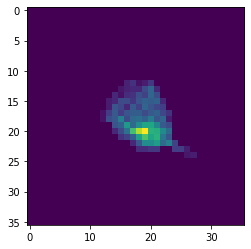

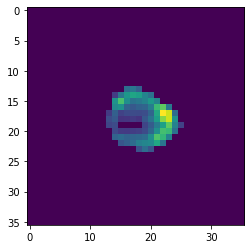

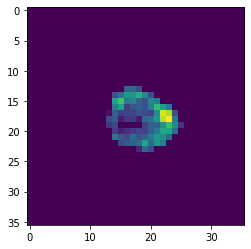

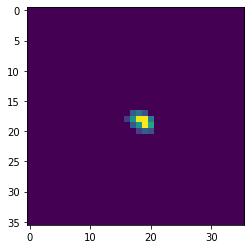

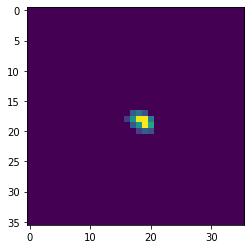

In [24]:
%matplotlib inline
plt.figure()
plt.imshow(images_dup[1])
plt.figure()
plt.imshow(images_aug_noisy[1])
plt.figure()
plt.imshow(images_dup[5])
plt.figure()
plt.imshow(images_aug_noisy[5])
plt.figure()
plt.imshow(images_dup[6])
plt.figure()
plt.imshow(images_aug_noisy[6])
plt.figure()
plt.imshow(images_dup[7])
plt.figure()
plt.imshow(images_aug_noisy[7])
plt.figure()
plt.imshow(images_dup[8])
plt.figure()
plt.imshow(images_aug_noisy[8])
plt.figure()
plt.imshow(images_dup[9])
plt.figure()
plt.imshow(images_aug_noisy[9])
plt.figure()
plt.imshow(images_dup[10])
plt.figure()
plt.imshow(images_aug_noisy[10])

0.30646418497645234
0.0
5
0
(1548, 1, 36, 36)
(1548,)


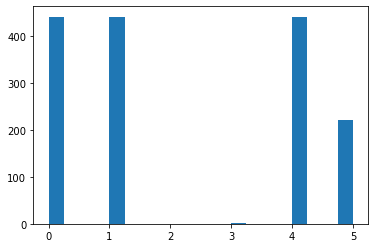

In [25]:
images_toUse = copy.deepcopy(images_aug)

# normalize
for ii in range(images_toUse.shape[0]):
    images_toUse[ii] = images_toUse[ii] / np.sum(images_toUse[ii]) 

# %matplotlib inline
# data_y = copy.deepcopy(labels[:643])
# data_y = np.int16(data_y - 1)

# data_y = train_y
# data_y = copy.deepcopy(labels_posthoc_filledIn)
data_y = copy.deepcopy(labels_aug)
# data_y = labels
# data_y = copy.deepcopy(train_y)

# data_x = images[:643,:,:]
# data_x = images
# data_x = train_x
# data_x = images_aug
# data_x = images_aug_noisy
data_x = images_toUse
# data_x = images_dup
# data_x = data_x / np.max(np.max(data_x, axis=2) , axis=1)[:,None,None]


# sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

# train.head()

print(np.max(data_x))
print(np.min(data_x))
print(np.max(data_y))
print(np.min(data_y))
# plt.figure()
# plt.imshow(np.squeeze(data_y[3,:,:,:]))
# data_y
plt.figure()
plt.hist(data_y,20);

# converting training images into torch format
data_x = data_x[:,None,:,:]
# train_x  = torch.from_numpy(train_x)
#data_x = torch.as_tensor(data_x)#.type('torch.cuda.FloatTensor')

# converting the target into torch format
data_y = data_y.astype(int);
# train_y = torch.from_numpy(train_y)
#data_y = torch.as_tensor(data_y)#.type('torch.cuda.LongTensor')

# shape of training data
print(data_x.shape)
print(data_y.shape)

In [26]:
data_x.shape

(1548, 1, 36, 36)

In [27]:
heldOut_x = val_x[: , None , : , :] #torch.as_tensor(val_x[: , None , : , :])#.type('torch.cuda.FloatTensor')
heldOut_y = val_y.astype(int) #torch.as_tensor(val_y.astype(int))#.type('torch.cuda.LongTensor')
print(heldOut_x.shape)
print(heldOut_y.shape)

(1458, 1, 36, 36)
(1458,)


In [28]:
from sklearn.metrics import accuracy_score
import tensorflow as tf
keras = tf.keras
layers = keras.layers
regularizers = keras.regularizers

# Reorganize "x" Data to Have Channels as Last Dimension
reorg_x = lambda x: np.transpose(x,(0,2,3,1))

In [29]:
# Define LeNet Architecture (with L1 / L2 regularization in place of DropOut)

l1_reg = 1e-5
l2_reg = 1e-4

rich_model = keras.Sequential([
    layers.Conv2D(16, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(16, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(32, 5, (1,1), padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    layers.Conv2D(64, 5, (1,1),
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       ),
    layers.MaxPool2D((2,2), 2),
    layers.Activation(keras.activations.relu),
    
    layers.Flatten(),
    
    layers.Dense(256),
    layers.Activation(keras.activations.relu),
    layers.Dense(6)
    
])



In [30]:
# Define an identity block for ResNet
# Adapted From: https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
def make_ResNet_conv_block(inp,
                           kernel_size=5,
                           filt=(16,32,64),
                           strides=(2,2),
                           l1_reg=1e-5,
                           l2_reg=1e-4):
    
    filt1, filt2, filt3 = filt[0], filt[1], filt[2]

    prv = layers.Conv2D(filt1, (1, 1), strides,
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt2, (kernel_size, kernel_size), (1,1),
                        kernel_initializer='he_normal', padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt3, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)

    shrt = layers.Conv2D(filt3, (1,1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    shrt = layers.BatchNormalization(axis=3)(shrt)

    prv = layers.Lambda(lambda x: x[0] + x[1])([prv, shrt])

    return prv
    

In [31]:
# Define an identity block for ResNet
# Adapted From: https://github.com/keras-team/keras-applications/blob/master/keras_applications/resnet50.py
def make_ResNet_id_block(inp,
                           kernel_size=5,
                           filt=(16,32,64),
                           l1_reg=1e-5,
                           l2_reg=1e-4):
    
    filt1, filt2, filt3 = filt[0], filt[1], filt[2]

    prv = layers.Conv2D(filt1, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt2, (kernel_size, kernel_size), (1,1),
                        kernel_initializer='he_normal', padding='same',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(inp)
    prv = layers.BatchNormalization(axis=3)(prv)
    prv = layers.Activation('relu')(prv)

    prv = layers.Conv2D(filt3, (1, 1), (1,1),
                        kernel_initializer='he_normal',
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)
                       )(prv)
    prv = layers.BatchNormalization(axis=3)(prv)

    prv = layers.Lambda(lambda x: x[0] + x[1])([prv, inp])

    return prv
    

In [113]:
# Create ResNet Architecture

inp = layers.Input(shape=reorg_x(data_x).shape[1:])

prv = make_ResNet_conv_block(inp, 5, [16, 32, 64], strides=(1,1))
# prv = make_ResNet_id_block(prv, 5, [16, 32, 64])
# prv = make_ResNet_id_block(prv, 5, [16, 32, 64])

# prv = make_ResNet_conv_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])
# prv = make_ResNet_id_block(prv, 3, [128, 128, 512])

# prv = make_ResNet_conv_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])
# prv = make_ResNet_id_block(prv, 3, [256, 256, 1024])

# prv = make_ResNet_conv_block(prv, 3, [512, 512, 2048])
# prv = make_ResNet_id_block(prv, 3, [512, 512, 2048])
# prv = make_ResNet_id_block(prv, 3, [512, 512, 2048])

prv = layers.Flatten()(prv)

layers.Dense(256)(prv)
layers.Activation(keras.activations.relu)(prv)

out = layers.Dense(6, activation='softmax')(prv)

# out = prv

jz_model = keras.Model(inputs=[inp], outputs=[out])

In [114]:
# Select Model Architecture to Train

# model = rich_model
model = jz_model

In [115]:
# Data Augmentation Generator
# Adapted from: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    shear_range=5,
#     width_shift_range=(-0.05,0.05),
#     height_shift_range=(-0.05,0.05),
#     brightness_range=(-0.1, 0.1),
#     zoom_range=(0.7, 1.4),
#     preprocessing_function=lambda x: x / np.sum(x) 
)

In [1]:
# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy']
             )


# Save Training Curve Data
history = model.fit(datagen.flow(reorg_x(data_x), data_y, batch_size=32),
                    validation_data=(reorg_x(heldOut_x), heldOut_y),
                    epochs=100)


'resnet_1'

NameError: name 'model' is not defined

In [ ]:
model.save('resnet_1')

<IPython.core.display.Javascript object>


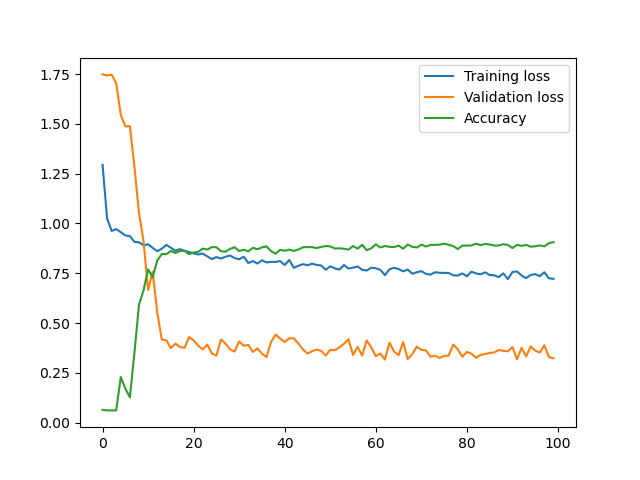

In [100]:
# Generate Training Curves

train_losses = history.history['loss']
val_losses = history.history['val_loss']
accuracy_running = history.history['val_accuracy']

%matplotlib notebook
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss') 
plt.plot(accuracy_running, label='Accuracy')
plt.legend()
plt.show()


<ipython-input-110-001bc3b9e714>:21: RuntimeWarning: invalid value encountered in true_divide
  matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)


<IPython.core.display.Javascript object>


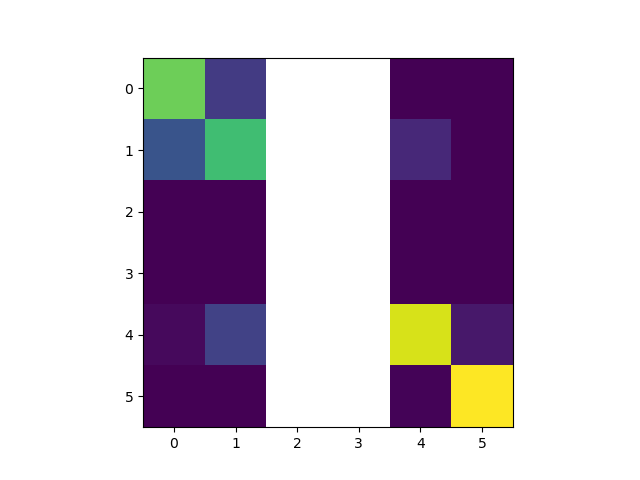

In [110]:
# Generate Confusion Matrix

%matplotlib notebook
%matplotlib notebook

# chk_model = keras.models.load_model('resnet_1')
chk_model = model

output = chk_model.predict(val_x)

prob = output
predictions = np.argmax(prob, axis=1)

# val_y_bool = np.zeros((len(val_y) , np.max(val_y.numpy())-1))
heldOut_y_bool = np.zeros((len(heldOut_y) , 6))
predictions_bool = np.zeros((len(heldOut_y) , 6))
for ii in range(6):
    heldOut_y_bool[:,ii] = (heldOut_y == ii)
    predictions_bool[:,ii] = (predictions==ii)
# plt.figure()
# plt.imshow(predictions_bool)

from numpy import matlib
matrix_probability = (predictions_bool.T @ heldOut_y_bool) / matlib.repmat(np.sum(heldOut_y_bool,axis=0) , 6,1)
plt.ion()
plt.figure()
plt.imshow(matrix_probability);
plt.show()

In [111]:
# Print Numerical Confusion Matrix

pd.DataFrame(matrix_probability)

,0,1,2,3,4,5
0,0.733333,0.162791,NaN,NaN,0.000000,0.000000
1,0.244444,0.651163,NaN,NaN,0.107843,0.000847
2,0.000000,0.000000,NaN,NaN,0.000000,0.000000
3,0.000000,0.000000,NaN,NaN,0.000000,0.000000
4,0.022222,0.186047,NaN,NaN,0.882353,0.059322
5,0.000000,0.000000,NaN,NaN,0.009804,0.939831
